In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix

# Load dataset.
dftrain = pd.read_csv('../../data/train.csv', sep='|')
y_train = dftrain.pop('fraud')

In [5]:
dftrain.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111


In [6]:
import tensorflow as tf
tf.random.set_seed(123)

In [7]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = []
NUMERIC_COLUMNS = [
    'trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
    'scansWithoutRegistration', 'quantityModifications',
    'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition'
]

def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
        fc.categorical_column_with_vocabulary_list(feature_name, vocab))


feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [8]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)


def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset

    return input_fn


# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
#eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [10]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(train_input_fn)
clear_output()
pd.Series(result).to_frame()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SEBAST~1\\AppData\\Local\\Temp\\tmp3fy7wdis', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001587EC4DF60>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflo

KeyboardInterrupt: 

In [ ]:
params = {
    'n_trees': 50,
    'max_depth': 3,
    'n_batches_per_layer': 1,
    # You must enable center_bias = True to get DFCs. This will force the model to
    # make an initial prediction before using any features (e.g. use the mean of
    # the training labels for regression or log odds for classification when
    # using cross entropy loss).
    'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(train_input_fn)
clear_output()
pd.Series(results).to_frame()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\SEBAST~1\\AppData\\Local\\Temp\\tmp5bqgxkuz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000158065DE748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflo

In [ ]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [ ]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

# Train the model.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
print(est.evaluate(eval_input_fn))

In [ ]:
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [ ]:
pred_dicts = list(est.experimental_predict_with_explanations(train_input_fn))

In [ ]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

In [ ]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values, probs.values)

In [ ]:
# Boilerplate code for plotting :)
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red


def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord,
                 y_coord + 1 - OFFSET,
                 'feature\nvalue',
                 fontproperties=font,
                 size=12)


def plot_example(example):
    sorted_ix = example.abs().sort_values().index  # Sort by magnitude.
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                                 color=[colors],
                                 legend=None,
                                 alpha=0.75,
                                 figsize=(10, 6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

    # Add feature values.
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
    return ax

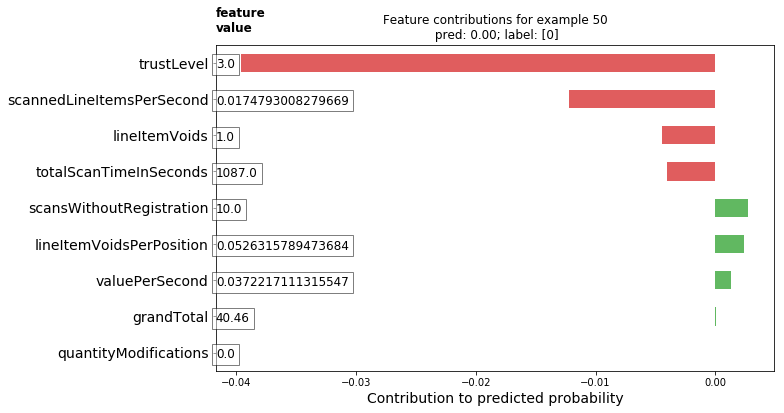

In [53]:
# Plot results.
ID = 50
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
sorted_ix = example.abs().sort_values().index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [60]:
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
    # Initialize plot.
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Create example dataframe.
    example = df_dfc.iloc[ID]
    ix = example.abs().sort_values().index
    example = example[ix]
    example_df = example.to_frame(name='dfc')

    # Add contributions of entire distribution.
    parts = ax.violinplot([df_dfc[w] for w in ix],
                          vert=False,
                          showextrema=False,
                          widths=0.7,
                          positions=np.arange(len(ix)))
    face_color = sns_colors[0]
    alpha = 0.15
    for pc in parts['bodies']:
        pc.set_facecolor(face_color)
        pc.set_alpha(alpha)

    # Add feature values.
    _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

    # Add local contributions.
    ax.scatter(example,
               np.arange(example.shape[0]),
               color=sns.color_palette()[2],
               s=100,
               marker="s",
               label='contributions for example')

    # Legend
    # Proxy plot, to show violinplot dist on legend.
    ax.plot([0, 0], [1, 1],
            label='eval set contributions\ndistributions',
            color=face_color,
            alpha=alpha,
            linewidth=10)
    legend = ax.legend(loc='lower right',
                       shadow=True,
                       fontsize='x-large',
                       frameon=True)
    legend.get_frame().set_facecolor('white')

    # Format plot.
    ax.set_yticks(np.arange(example.shape[0]))
    ax.set_yticklabels(example.index)
    ax.set_xlim(-.2, .2)
    ax.grid(False, axis='y')
    ax.set_xlabel('Contribution to predicted probability', size=14)

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

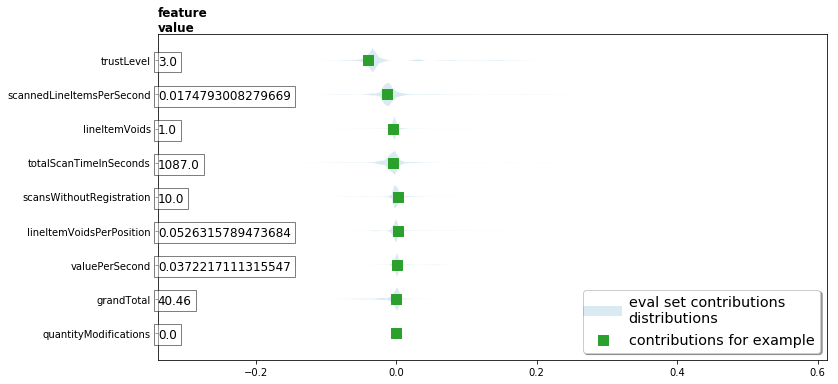

In [59]:
dist_violin_plot(df_dfc, ID)
plt.title(
    'Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(
        ID, probs[ID], labels[ID]))
plt.show()

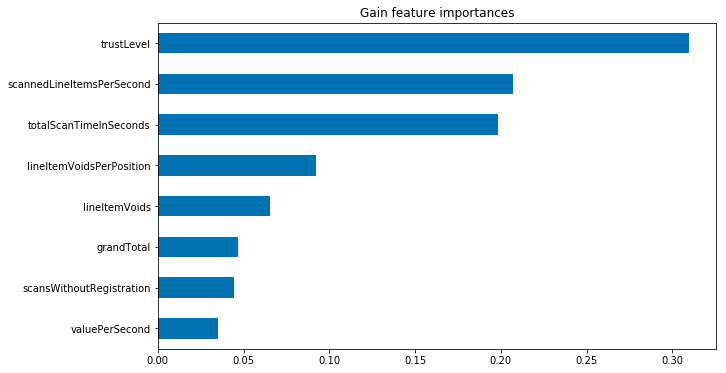

In [31]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
ax = (df_imp.iloc[::-1].plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')

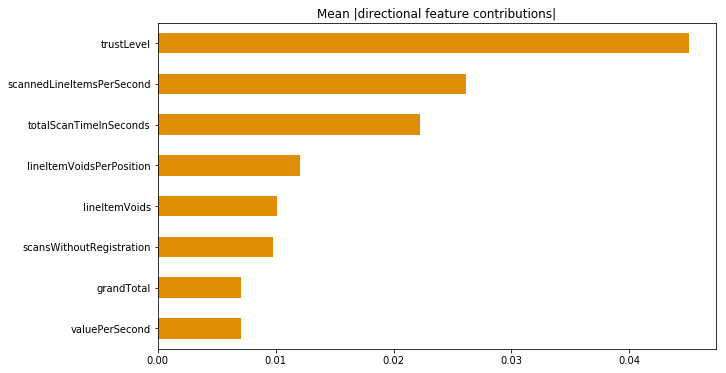

In [32]:
# Plot.
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

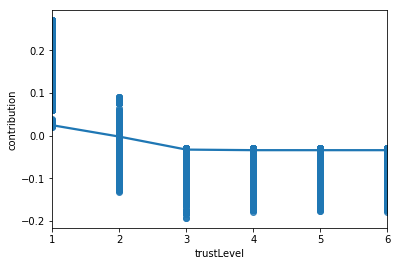

In [36]:
FEATURE = 'trustLevel'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index()
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(1, 6)
plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-15T16:56:16Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/w0/79lvc8l94m5_57rlk16lpfyjh0x6gd/T/tmpc0klphj2/model.ckpt-155
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-15-16:56:25
INFO:tensorflow:Saving dict for global step 155: accuracy = 0.9790914, accuracy_baseline = 0.952367, auc = 0.99050725, auc_precision_recall = 0.86929435, average_loss = 0.051266707, global_step = 155, label/mean = 0.047633003, loss = 0.05132165, precision = 0.8293745, prediction/mean = 0.046096478, recall = 0.70636827
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 155: /var/folders/w0/79lvc8l94m5_57rlk16lpfyjh0x6gd/T/tmpc0klphj2/model.ckpt-155
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evalua

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-15T16:59:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/w0/79lvc8l94m5_57rlk16lpfyjh0x6gd/T/tmpc0klphj2/model.ckpt-155
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-15-16:59:28
INFO:tensorflow:Saving dict for global step 155: accuracy = 0.9389606, accuracy_baseline = 0.952367, auc = 0.8766182, auc_precision_recall = 0.3913863, average_loss = 0.18188839, global_step = 155, label/mean = 0.047633003, loss = 0.18192902, precision = 0.37403804, prediction/mean = 0.058786534, recall = 0.41787836
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 155: /var/folders/w0/79lvc8l94m5_57rlk16lpfyjh0x6gd/T/tmpc0klphj2/model.ckpt-155
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-15T16:59:41Z
INFO:te

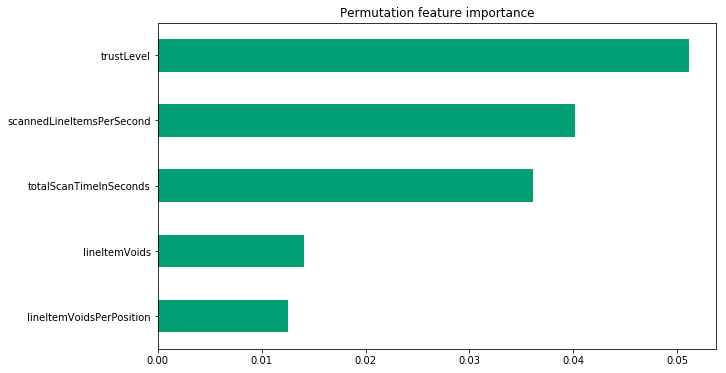

In [37]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()

In [38]:
from numpy.random import uniform, seed
from matplotlib.mlab import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)

In [39]:
# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [40]:
def plot_contour(x, y, z, **kwargs):
  # Grid the data.
  plt.figure(figsize=(10, 8))
  # Contour the gridded data, plotting dots at the nonuniform data points.
  CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
  CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
  plt.colorbar()  # Draw colorbar.
  # Plot data points.
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

/Users/taahase8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.
  """Entry point for launching an IPython kernel.


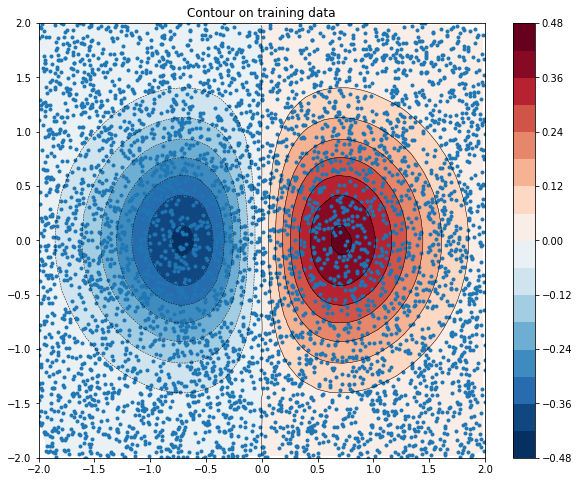

In [41]:
zi = griddata(x, y, z, xi, yi, interp='linear')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [42]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

In [43]:
def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)

In [44]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/w0/79lvc8l94m5_57rlk16lpfyjh0x6gd/T/tmp404c6xln', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x6390a3d10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow

In [45]:
train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/w0/79lvc8l94m5_57rlk16lpfyjh0x6gd/T/tmpuihokk6e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x63a3fa810>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/w0/79lvc8l94m5_57rlk16lpfyjh0x6gd/T/tmpuihokk6e/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


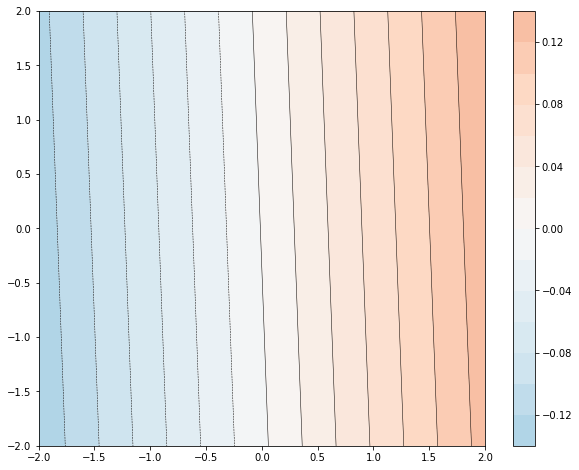

In [46]:
plot_contour(xi, yi, predict(est))

In [47]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(n_trees=22)
def show_fit(n_trees):
    est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees)
    est.train(train_input_fn, max_steps=500)
    clear_output()
    plot_contour(xi, yi, predict(est))
    plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)
    plt.show()

interactive(children=(IntSlider(value=22, description='n_trees', max=66, min=-22), Output()), _dom_classes=('w…

In [13]:
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_trees=50,
                                          max_depth=3,
                                          n_batches_per_layer=1,
                                          center_bias=True)

# Train model.
history = est.train(train_input_fn, max_steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/w0/79lvc8l94m5_57rlk16lpfyjh0x6gd/T/tmp6iaytqgl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x643f5eb50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow

In [50]:
pred_dicts = list(est.predict(eval_input_fn))
y_pred = np.array([pred['probabilities'][1] for pred in pred_dicts])

In [51]:
y_pred.shape

(498121,)

0.01 -2353335
0.11 -431420
0.21 -238855
0.31 -144090
0.41 -82605
0.51 -40035
0.61 -26280
0.71 -21705
0.81 -45105
0.91 -86120
0.71
-21705


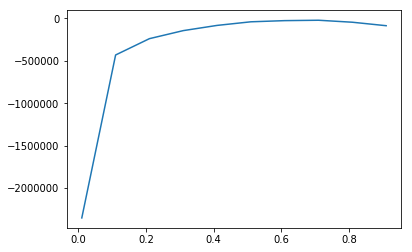

In [58]:
def score_evaluation(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    score = 0
    score += conf[0][1] * -25
    score += conf[1][0] * -5
    score += conf[1][1] * 5
    
    return score


best_thresh = 0
max_score = -100000

thresholds = []
scores = []

for thresh in range(1, 100, 10):
    thresh = thresh / 100
    
    y_pred_local = y_pred.copy()
    
    y_pred_local[y_pred_local >= thresh] = 1
    y_pred_local[y_pred_local < thresh] = 0

    score = score_evaluation(y_eval, y_pred_local)
    thresholds.append(thresh)
    
    scores.append(score)
    print(thresh, score)
    
    if score > max_score:
        best_thresh = thresh
        max_score = score

plt.plot(thresholds, scores)

print(best_thresh)
print(max_score)